# Visualize patched sphere simulations

In [1]:
%cd ..

/home/gridsan/dkannan/git-remotes/protein_mobility


In [2]:
import nglutils as ngu
import nglview as nv

import os
import sys
from pathlib import Path
import numpy as np
import scipy as sp
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt

import mdtraj
import polychrom
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

In [3]:
%matplotlib inline

In [4]:
slide_width = 11.5
half_slide_width = 5.67
aspect_ratio = 5/7
pres_params = {'axes.edgecolor': 'black',
                  'axes.facecolor':'white',
                  'axes.grid': False,
                  'axes.linewidth': 0.5,
                  'backend': 'ps',
                  'savefig.format': 'pdf',
                  'axes.titlesize': 20,
                  'axes.labelsize': 18,
                  'legend.fontsize': 18,
                  'xtick.labelsize': 16,
                  'ytick.labelsize': 16,
                  'text.usetex': False,
                  'figure.figsize': [half_slide_width, half_slide_width * aspect_ratio],
                  'font.family': 'sans-serif',
                   'font.size': 14,
                  #'mathtext.fontset': 'cm',
                  'xtick.bottom':True,
                  'xtick.top': False,
                  'xtick.direction': 'out',
                  'xtick.major.pad': 3,
                  'xtick.major.size': 3,
                  'xtick.minor.bottom': False,
                  'xtick.major.width': 0.2,

                  'ytick.left':True,
                  'ytick.right':False,
                  'ytick.direction':'out',
                  'ytick.major.pad': 3,
                  'ytick.major.size': 3,
                  'ytick.major.width': 0.2,
                  'ytick.minor.right':False,
                  'lines.linewidth':2}
plt.rcParams.update(pres_params)

In [5]:
def extract_trajectory(simdir, wrap=False, start=0, end=-1, every_other=10):
    """Load conformations from a simulation trajectory stored in the hdf5 files in simdir.
    
    Parameters
    ----------
    simdir : str or Path
        path to simulation directory containing .h5 files
    start : int
        which time block to start loading conformations from
    end : int
        which time block to stop loading conformations from
    every_other : int
        skip every_other time steps when loading conformations
        
    Returns
    -------
    X : array_like (num_t, N, 3)
        x, y, z positions of all monomers over time
    
    """
    X = []
    data = list_URIs(simdir)
    #check if PBCbox was used
    initArgs = load_hdf5_file(Path(simdir)/"initArgs_0.h5")
    PBCbox = np.array(initArgs['PBCbox'])
    if PBCbox.any():
        boxsize = PBCbox
    if start == 0:
        starting_pos = load_hdf5_file(Path(simdir)/"starting_conformation_0.h5")['pos']
        X.append(starting_pos)
    for conformation in data[start:end:every_other]:
        pos = load_URI(conformation)['pos']
        if PBCbox.any() and wrap:
            mults = np.floor(pos / boxsize[None, :])
            pos = pos - mults * boxsize[None, :]
            assert pos.min() >= 0
        X.append(pos)
    X = np.array(X)
    return X, boxsize

def patched_particle_geom(f, R=1):
    """ Distribute f residues on a sphere with equal angles."""
    
    #first position is center particle
    positions = [[0., 0., 0.]]
    theta = np.pi/2
    for i in range(min(f, 5)):
        #for valency less than 5, just distribute points on a circle in the x-y plane
        phi = 2 * np.pi * i / f
        x = R * np.sin(theta) * np.cos(phi)
        y = R * np.sin(theta) * np.sin(phi)
        z = R * np.cos(theta)
        positions.append([x, y, z])
    
    if f >=5:
        #octahedron -> put 5th particle perpendicular to plain of 4 points
        print("Have not implemented yet")
    return np.array(positions)

#make a topology for this f+1-atom chain
def mdtop_for_patched_particles(N, nchains, f, atom_names="XXX"):
    """
    Generate an mdtraj.Topology object for a single polymer of length N.

    Parameters
    ----------
    N : int
        total number of particles
    nchains : int
        number of tetramers
    f : int
        valency, i.e. number of patches
    atom_names : string (up to 3 characters) or list of such
        names for the atoms. This can be useful for labelling different types
        of monomers, such as compartments. If given as list, should have length
        N.

    Notes
    -----
        - use iron as element to prevent NGLView from calculating bonds
    """

    # Check that atom names are good
    if isinstance(atom_names, str):
        atom_names = [atom_names[:3] for _ in range(N)]
    elif not isinstance(atom_names, list) or not len(atom_names) == N:
        print("WARNING: atom_names should be a list of length N = {}. Using default." % N)
        atom_names = ["XXX" for _ in range(N)]

    # Generate topology
    top = mdtraj.Topology()
    resi = 0
    for i in range(nchains):
        ch = top.add_chain()
        res = top.add_residue("{0:03d}".format(resi // 10000), ch)
        first_atom = top.add_atom(atom_names[resi], mdtraj.element.iron, res)
        resi += 1
        for k in range(f):
            res = top.add_residue("{0:03d}".format(resi // 10000), ch)
            cur_atom = top.add_atom(atom_names[resi], mdtraj.element.iron, res)
            top.add_bond(first_atom, cur_atom)
            resi += 1
    return top


In [6]:
DATADIR = Path('/home/gridsan/dkannan/git-remotes/protein_mobility/results')

In [7]:
def make_animation(f, E0, N=1000, vol_fraction=0.3, r=0.5, rep_r=1.05, wrap=True):
    if r != 0.5:
        Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r{r}_rep{rep_r}", 
                               wrap=wrap, start=0, end=1000, every_other=1)
    elif rep_r != 1.05:
        Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_rep{rep_r}", 
                               wrap=wrap, start=0, end=1000, every_other=1)
    else:
        Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}", wrap=wrap, 
                           start=0, end=1000, every_other=1)
    print(Y.shape)
    X = Y
    print(X.shape)
    N = int(Y.shape[1]/(f+1))
    print(N)
    print(X.shape)
    atom_names = (['B'] + ['A']*f) * N
    top = mdtop_for_patched_particles((f+1)*N, N, f, atom_names=atom_names)
    view = ngu.xyz2nglview(X, top=top)
    view.add_representation('ball+stick', selection='.A',
                                                colorScheme='uniform',
                                                colorValue=0xff4242, radius=0.15)
    view.add_representation('ball+stick', selection='.B', colorScheme='uniform',
                            colorValue=0x475FD0, radius=0.35)
    view.add_unitcell()
    return view

In [22]:
make_animation(2, 25.0, r=0.35, rep_r=1.1, wrap=False)

(1001, 3000, 3)
(1001, 3000, 3)
1000
(1001, 3000, 3)


NGLWidget(max_frame=1000)

## Test DBscan for clustering

In [8]:
import sklearn

In [9]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.sparse import csr_matrix, coo_matrix
from matplotlib import pyplot as plt

def particles_from_mols(mol_ids, f):
    """ Return particle IDs (including patches) from list of molecule IDs"""
    particles = []
    for mol in mol_ids:
        particles += [mol + i for i in range(f + 1)]
    return particles

In [10]:
#def cluster_snapshot(f, E0, snapshot_ind, N=1000, vol_fraction=0.3):
f = 1
N = 1000
E0 = 25.0
vol_fraction = 0.3
Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r0.35_rep1.1", wrap=False, 
                           start=10000, every_other=100)
Ywrapped, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r0.35_rep1.1", wrap=True, 
                           start=10000, every_other=100)
#indices of larger spheres
print(Y.shape)
print(boxsize)
molecule_inds = np.arange(0, (f+1)*N, f+1)
X = Y[-1, molecule_inds, :]
print(X.shape)

(50, 2000, 3)
[12.64197969 12.64197969 12.64197969]
(1000, 3)


In [42]:
X[:,0].max()

97.6

In [11]:
def pdist_PBC(X, boxsize):
    """ Pairwise distances with periodic boundary conditions. """
    N = X.shape[0]
    dim = X.shape[1]
    dist_nd_sq = np.zeros(N * (N - 1) // 2)  # to match the result of pdist
    for d in range(dim):
        pos_1d = X[:, d][:, np.newaxis]  # shape (N, 1)
        dist_1d = pdist(pos_1d)  # shape (N * (N - 1) // 2, )
        dist_1d -= boxsize[d] * np.rint(dist_1d / boxsize[d])
        dist_nd_sq += dist_1d ** 2  # d^2 = dx^2 + dy^2 + dz^2
    dist_nd = np.sqrt(dist_nd_sq)
    return dist_nd

def cdist_PBC(X, Y, boxsize):
    cdist_nd_sq = np.zeros((X.shape[0], Y.shape[0]))
    dim = len(boxsize)
    for d in range(dim):
        xpos_1d = X[:, d][:, np.newaxis]  # shape (N, 1)
        ypos_1d = Y[:, d][:, np.newaxis]  # shape (M, 1)
        dist_1d = cdist(xpos_1d, ypos_1d)  # shape (N, M)
        dist_1d -= boxsize[d] * np.rint(dist_1d / boxsize[d])
        cdist_nd_sq += dist_1d ** 2  # d^2 = dx^2 + dy^2 + dz^2
    dist_nd = np.sqrt(cdist_nd_sq)
    return dist_nd


In [71]:
%%time
distances = pdist(X)
len(distances[distances <= 1.1])

CPU times: user 6.11 ms, sys: 0 ns, total: 6.11 ms
Wall time: 5.12 ms


851

In [68]:
len(distances[distances <= 1.1])

987

In [12]:
distances = pdist_PBC(X, boxsize)
cutoff = 1.3
print(len(distances))
dist_matrix = squareform(distances)
dist_graph = dist_matrix.copy()
dist_graph[dist_matrix > cutoff] = 0.0 #dist_graph is dense and symmetric
dist_graph_lower = dist_graph.copy()
#set the lower triangle to zero since its redundant
lower_triangle_indices = np.tril_indices(dist_graph_lower.shape[0], k=-1)
dist_graph_lower[lower_triangle_indices] = 0.0
print(np.sum(dist_graph_lower > 0)) #dist graph lower is dense and upper triangular
print(len(distances[distances <= cutoff]))
dist_graph_sparse = coo_matrix(dist_graph_lower)
print(dist_graph_sparse)

499500
2003
2003
  (0, 37)	1.1442654972699913
  (0, 185)	1.2587403270424535
  (0, 220)	1.0114223513108658
  (0, 459)	1.1957879462688241
  (0, 895)	1.1241757558495056
  (1, 640)	1.1531845022047038
  (1, 858)	1.1471697221622108
  (2, 137)	1.2938074424288692
  (2, 154)	1.1073821965466162
  (2, 745)	1.193582256395759
  (2, 759)	1.1741625530857043
  (2, 787)	1.1953239534235975
  (2, 903)	1.212359098157154
  (3, 102)	1.1827638445905433
  (3, 142)	1.2043731100272017
  (3, 346)	1.2505362574649248
  (3, 430)	1.2651051921320338
  (4, 19)	1.1001797729249592
  (4, 194)	1.1754512435274775
  (4, 318)	1.2402078527547051
  (4, 573)	1.2844935102983146
  (5, 573)	1.1876712702629473
  (5, 577)	1.1933623645776992
  (5, 597)	1.1667376066385542
  (5, 884)	1.2682560889287964
  :	:
  (896, 931)	1.1580632668355368
  (899, 955)	1.1839135934494975
  (905, 912)	1.139480685193476
  (905, 917)	1.1127702694554997
  (905, 936)	1.147505984058286
  (912, 917)	1.2151670607691
  (917, 936)	1.1030456561723705
  (921, 961)

In [13]:
#prune edges in sparse graph where inter-patch distances are > 0.5

#copy a dense matrix here (dist_graph is dense and symmetric)
#for edge in sparse graph
for i, (r, c, d) in enumerate(zip(dist_graph_sparse.row, dist_graph_sparse.col, dist_graph_sparse.data)):
    node1_patches = np.array([Y[-1, r*(f+1) + k, :] for k in range(1, f+1)])
    node2_patches = np.array([Y[-1, c*(f+1) + k, :] for k in range(1, f+1)])
    inter_patch_distances = cdist_PBC(node1_patches, node2_patches, boxsize)
    if np.all(inter_patch_distances > 0.55):
        print(f"Deleted edge {i}: ({r}, {c}) with weight {d}")
        dist_graph[r, c] = 0.0
        dist_graph[c, r] = 0.0

#if you havent found a single patch-patch distances within interaction range, remove edge
#dist_graph[r, c] = 0.0
print(np.sum(dist_graph > 0) / 2)

Deleted edge 0: (0, 37) with weight 1.1442654972699913
Deleted edge 1: (0, 185) with weight 1.2587403270424535
Deleted edge 2: (0, 220) with weight 1.0114223513108658
Deleted edge 3: (0, 459) with weight 1.1957879462688241
Deleted edge 5: (1, 640) with weight 1.1531845022047038
Deleted edge 6: (1, 858) with weight 1.1471697221622108
Deleted edge 7: (2, 137) with weight 1.2938074424288692
Deleted edge 10: (2, 759) with weight 1.1741625530857043
Deleted edge 11: (2, 787) with weight 1.1953239534235975
Deleted edge 12: (2, 903) with weight 1.212359098157154
Deleted edge 14: (3, 142) with weight 1.2043731100272017
Deleted edge 15: (3, 346) with weight 1.2505362574649248
Deleted edge 16: (3, 430) with weight 1.2651051921320338
Deleted edge 18: (4, 194) with weight 1.1754512435274775
Deleted edge 19: (4, 318) with weight 1.2402078527547051
Deleted edge 20: (4, 573) with weight 1.2844935102983146
Deleted edge 21: (5, 573) with weight 1.1876712702629473
Deleted edge 22: (5, 577) with weight 1.

In [82]:
r = 923
c = 999
node1_patches = np.array([Y[-1, r*(f+1) + k, :] for k in range(1, f+1)])
node2_patches = np.array([Y[-1, c*(f+1) + k, :] for k in range(1, f+1)])
inter_patch_distances = cdist_PBC(node1_patches, node2_patches, boxsize)
inter_patch_distances

array([[1.44369959]])

In [26]:
particles = particles_from_mols([r, c], f)
print(particles)
cluster_size = 2 #single edge
atom_names = (['B'] + ['A']*f) * cluster_size
top = mdtop_for_patched_particles((f+1)*cluster_size, cluster_size, f, atom_names=atom_names)
view = ngu.xyz2nglview(Y[-1, particles, :], top=top)
view.add_representation('ball+stick', selection='.A',
                                            colorScheme='uniform',
                                            colorValue=0xff4242, radius=0.15)
view.add_representation('ball+stick', selection='.B', colorScheme='uniform',
                        colorValue=0xA2A2A2, radius=0.3)
view

[1846, 1847, 1800, 1801]


NGLWidget()

In [14]:
dist_graph_sparse = csr_matrix(dist_graph)
dist_graph_sparse = sklearn.neighbors.sort_graph_by_row_values(dist_graph_sparse)
#clustering based on adjacency matrix (should yield same result)
clustering = DBSCAN(eps=cutoff, min_samples=2, metric="precomputed").fit(dist_graph_sparse)
unique_values, counts = np.unique(clustering.labels_, return_counts=True)
if len(counts) > 1:
    print(f"Distance cutoff = {cutoff}, # clusters = {len(unique_values)-1}, max cluster size = {counts[1:].max()}")

Distance cutoff = 1.3, # clusters = 330, max cluster size = 4


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


In [15]:
a, b = np.unique(counts[1:], return_counts=True)
print(a)
print(b)

[2 3 4]
[197 132   1]


In [16]:
for cluster in unique_values:
    mols_in_cluster = molecule_inds[clustering.labels_==cluster]
    particles = particles_from_mols(mols_in_cluster, 1)
    inter_cluster_distances = pdist(Y[-1, mols_in_cluster, :])
    if len(mols_in_cluster) >= 2:
        print(f"Cluster {cluster} with {len(mols_in_cluster)} molecules")

Cluster -1 with 206 molecules
Cluster 0 with 2 molecules
Cluster 1 with 3 molecules
Cluster 2 with 2 molecules
Cluster 3 with 2 molecules
Cluster 4 with 2 molecules
Cluster 5 with 2 molecules
Cluster 6 with 3 molecules
Cluster 7 with 3 molecules
Cluster 8 with 2 molecules
Cluster 9 with 3 molecules
Cluster 10 with 3 molecules
Cluster 11 with 2 molecules
Cluster 12 with 2 molecules
Cluster 13 with 2 molecules
Cluster 14 with 2 molecules
Cluster 15 with 3 molecules
Cluster 16 with 3 molecules
Cluster 17 with 2 molecules
Cluster 18 with 2 molecules
Cluster 19 with 2 molecules
Cluster 20 with 2 molecules
Cluster 21 with 3 molecules
Cluster 22 with 3 molecules
Cluster 23 with 2 molecules
Cluster 24 with 2 molecules
Cluster 25 with 3 molecules
Cluster 26 with 3 molecules
Cluster 27 with 3 molecules
Cluster 28 with 3 molecules
Cluster 29 with 3 molecules
Cluster 30 with 3 molecules
Cluster 31 with 3 molecules
Cluster 32 with 2 molecules
Cluster 33 with 3 molecules
Cluster 34 with 3 molecules


In [17]:
mols_in_cluster = molecule_inds[clustering.labels_==17]
particles = particles_from_mols(mols_in_cluster, f)
print(mols_in_cluster)

[  44 1636]


In [18]:
cluster_size = len(mols_in_cluster)
atom_names = (['B'] + ['A']*f) * cluster_size
top = mdtop_for_patched_particles((f+1)*cluster_size, cluster_size, f, atom_names=atom_names)
view = ngu.xyz2nglview(Ywrapped[-1, particles, :], top=top)
view.add_representation('ball+stick', selection='.A',
                                            colorScheme='uniform',
                                            colorValue=0xff4242, radius=0.15)
view.add_representation('ball+stick', selection='.B', colorScheme='uniform',
                        colorValue=0xA2A2A2, radius=0.3)
view

NGLWidget()

In [19]:
def cluster_size_distribution(f, E0, N=1000, vol_fraction=0.3, r=0.5, rep_r=1.05,
                              cutoff=1.2, wrap=False):
    if r != 0.5:
        Y = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r{r}", wrap=wrap, 
                               start=10000, every_other=100)
    elif rep_r != 1.05:
        Y = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_rep{rep_r}", 
                               wrap=wrap, start=10000, every_other=100)
    else:
        Y = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}", wrap=wrap, 
                               start=10000, every_other=100)
    #indices of larger spheres
    molecule_inds = np.arange(0, (f+1)*N, f+1)
    cluster_sizes = []
    for i in range(Y.shape[0]):
        X = Y[i, molecule_inds, :]
        clustering = DBSCAN(eps=cutoff, min_samples=2).fit(X)
        cluster_labels, counts = np.unique(clustering.labels_, return_counts=True)
        #first element of counts represents number of monomers
        cluster_sizes += counts[0] * [1] + list(counts[1:])
    return cluster_sizes

In [22]:
def cluster_size_distribution_pruned(f, E0, N=1000, vol_fraction=0.3, r=0.5, rep_r=1.05,
                              cutoff=1.3, wrap=False):
    if r != 0.5:
        Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r{r}_rep{rep_r}", wrap=wrap, 
                               start=10000, every_other=10)
    elif rep_r != 1.05:
        Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_rep{rep_r}_conf", 
                               wrap=wrap, start=10000, every_other=10)
    else:
        Y, boxsize = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}", wrap=wrap, 
                               start=10000, every_other=10)
    #indices of larger spheres
    molecule_inds = np.arange(0, (f+1)*N, f+1)
    cluster_sizes = []
    cluster_histogram = np.zeros(1000)
    print(Y.shape[0])
    for i in range(Y.shape[0]):
        X = Y[i, molecule_inds, :]
        distances = pdist_PBC(X, boxsize)
        dist_graph = squareform(distances)
        dist_graph[dist_graph > cutoff] = 0.0 #dist_graph is dense and symmetric
        dist_graph_lower = dist_graph.copy()
        #set the lower triangle to zero since its redundant
        lower_triangle_indices = np.tril_indices(dist_graph_lower.shape[0], k=-1)
        dist_graph_lower[lower_triangle_indices] = 0.0
        dist_graph_sparse = coo_matrix(dist_graph_lower)
        #prune edges
        for i, (r, c, d) in enumerate(zip(dist_graph_sparse.row, dist_graph_sparse.col, dist_graph_sparse.data)):
            node1_patches = np.array([Y[-1, r*(f+1) + k, :] for k in range(1, f+1)])
            node2_patches = np.array([Y[-1, c*(f+1) + k, :] for k in range(1, f+1)])
            inter_patch_distances = cdist_PBC(node1_patches, node2_patches, boxsize)
            if np.all(inter_patch_distances > 0.55):
                dist_graph[r, c] = 0.0
                dist_graph[c, r] = 0.0
        if np.sum(dist_graph > 0) == 0:
            #all the edges were pruned. 
            cluster_sizes += dist_graph.shape[0] * [1]
            continue
        dist_graph_sparse = csr_matrix(dist_graph)
        dist_graph_sparse = sklearn.neighbors.sort_graph_by_row_values(dist_graph_sparse,
                                warn_when_not_sorted=False)
        clustering = DBSCAN(eps=cutoff, min_samples=2, metric="precomputed").fit(dist_graph_sparse)
        cluster_labels, counts = np.unique(clustering.labels_, return_counts=True)
        #first element of counts represents number of monomers
        cluster_sizes += counts[0] * [1] + list(counts[1:])
        cluster_histogram[0] += counts[0]
        multimers, number_observed = np.unique(counts[1:], return_counts=True)
        for m in range(len(multimers)):
            cluster_histogram[multimers[m] - 1] += number_observed[m] * multimers[m]
    return cluster_sizes, cluster_histogram 

In [23]:
import seaborn as sns

def plot_multimerization(f, N=1000, vol_fraction=0.3, r=0.5, rep_r=1.05,
                              cutoff=1.3, wrap=False):
    fig, ax = plt.subplots()
    E0_values = [0.0, 11.0, 20.0]
    colors = sns.color_palette("viridis", len(E0_values))
    for i, E0 in enumerate(E0_values):
        print(f'E0 = {E0}')
        cluster_sizes, histogram = cluster_size_distribution_pruned(f, E0, N=N, vol_fraction=vol_fraction, 
                                                         r=r, rep_r=rep_r, cutoff=cutoff, wrap=wrap)
        cluster_sizes = np.array(cluster_sizes)
        total = 0
        for n in range(max(cluster_sizes)):
            total += np.sum(cluster_sizes ==  n) * n
        print(total)
        print(f"Fraction in monomers: {np.sum(cluster_sizes == 1) / total}")
        print(f"Fraction in dimers: {np.sum(cluster_sizes == 2) * 2 / total}")
        multimers = 0
        for n in range(3, max(cluster_sizes)):
            multimers += np.sum(cluster_sizes == n) * n
        print(f"Fraction in multimers: {multimers / total}")
        counts, bins, patches = ax.hist(cluster_sizes, bins=np.arange(0, 1000, 1), density=True, 
                                        cumulative=True, histtype='step', color=colors[i], label=f'$E_0={E0}$')
    ax.set_xlabel('cluster size')
    ax.set_ylabel('CDF')
    ax.set_title(f'Multimerization landscape, f={f}, d={cutoff}')
    ax.set_xlim(0, 10)
    ax.legend(loc='lower right', fontsize=14)
    if r is None:
        r = 0.5
    plt.savefig(f'plots/multimerization_f{f}_cutoff{cutoff}_r{r}.pdf')
    return cluster_sizes, histogram

E0 = 0.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

99960
Fraction in monomers: 1.0
Fraction in dimers: 0.00040016006402561027
Fraction in multimers: 0.0
E0 = 2.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

99991
Fraction in monomers: 0.998719884789631
Fraction in dimers: 0.0012801152103689333
Fraction in multimers: 0.0
E0 = 4.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

99948
Fraction in monomers: 0.9957377836474967
Fraction in dimers: 0.003121623244086925
Fraction in multimers: 0.0011405931084163764
E0 = 7.0
98642
Fraction in monomers: 0.6822752985543683
Fraction in dimers: 0.03473165588694471
Fraction in multimers: 0.282993045558687


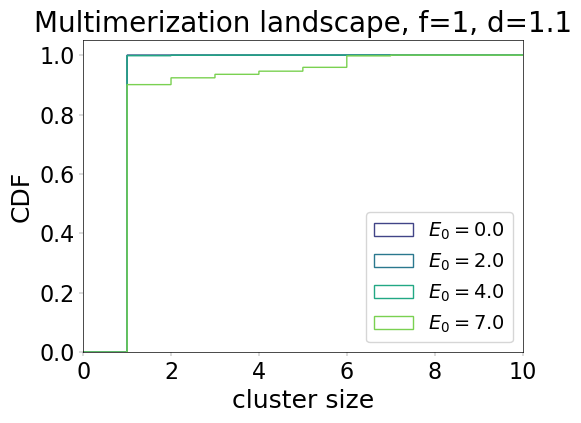

In [39]:
cluster_sizes = plot_multimerization(1, rep_r=1.1, cutoff=1.3, wrap=False)

E0 = 0.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


99988
Fraction in monomers: 1.0
Fraction in dimers: 0.00012001440172820739
Fraction in multimers: 0.0
E0 = 7.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

99732
Fraction in monomers: 0.9944551397745959
Fraction in dimers: 0.004070910038904263
Fraction in multimers: 0.0014739501864998196
E0 = 15.0
99566
Fraction in monomers: 0.24422995801779723
Fraction in dimers: 0.08054958519976699
Fraction in multimers: 0.6752204567824358


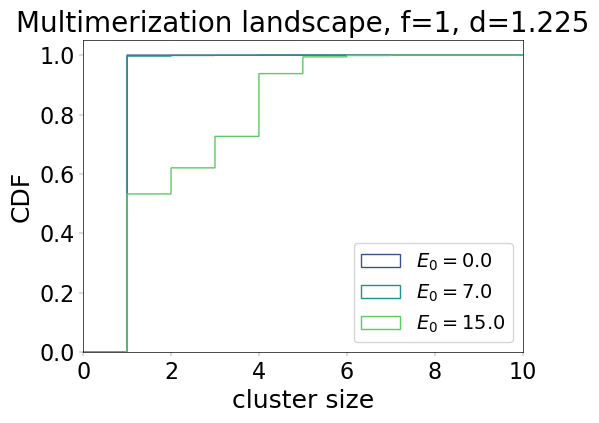

In [42]:
cluster_sizes = plot_multimerization(1, rep_r=1.175, cutoff=1.225, wrap=False)

In [ ]:
cluster_sizes, histogram = cluster_size_distribution_pruned(f, 15.0, N=1000, vol_fraction=0.3, 
                                                         r=0.5, rep_r=1.15, cutoff=1.3, wrap=False)

In [39]:
cluster_sizes, histogram = cluster_size_distribution_pruned(2, 25.0, N=1000, vol_fraction=0.3, 
                                                         r=0.35, rep_r=1.1, cutoff=1.3, wrap=False)

500


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

0.9999999999999999


Text(0.5, 1.0, 'f=2, $r_{rep}$=1.1, $r_{attr}$=0.35, $E_0$=25')

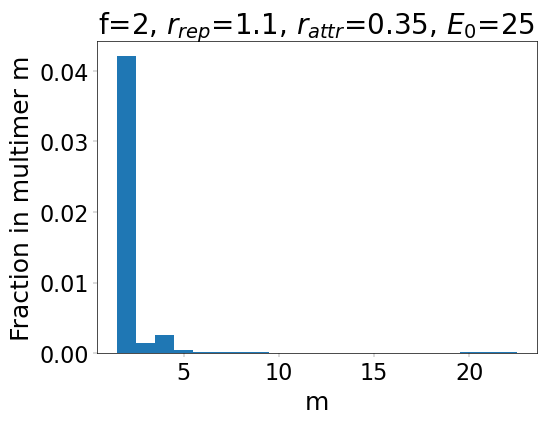

In [40]:
weights = histogram[histogram > 0] / histogram[histogram > 0].sum()
print(weights.sum())
cdf = np.cumsum(weights)
fig, ax = plt.subplots()
ax.bar(np.arange(2, len(weights) + 1), weights[1:], width=1.0)
ax.set_xlabel('m')
ax.set_ylabel('Fraction in multimer m')
ax.set_title('f=2, $r_{rep}$=1.1, $r_{attr}$=0.35, $E_0$=25')

In [37]:
cluster_sizes, histogram = cluster_size_distribution_pruned(1, 25.0, N=1000, vol_fraction=0.3, 
                                                         r=0.35, rep_r=1.05, cutoff=1.3, wrap=False)

500


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

1.0


Text(0.5, 1.0, 'f=1, $r_{rep}$=1.1, $r_{attr}$=0.35, $E_0$=25')

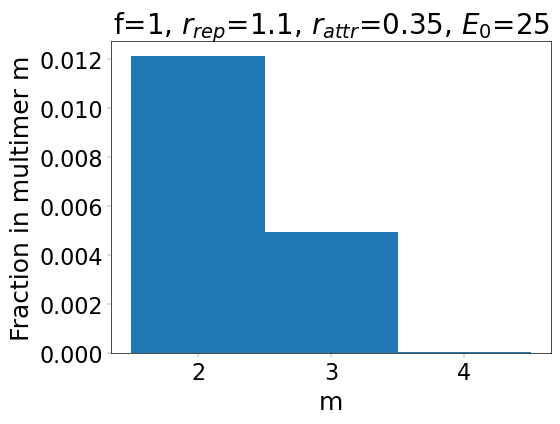

In [38]:
weights = histogram[histogram > 0] / histogram[histogram > 0].sum()
print(weights.sum())
cdf = np.cumsum(weights)
fig, ax = plt.subplots()
ax.bar(np.arange(2, len(weights) + 1), weights[1:], width=1.0)
ax.set_xlabel('m')
ax.set_ylabel('Fraction in multimer m')
ax.set_title('f=1, $r_{rep}$=1.1, $r_{attr}$=0.35, $E_0$=25')

In [41]:
weights = (histogram[histogram > 0] * np.array([1, 2, 3, 4])) / 1000
np.sum(weights)

0.9

E0 = 0.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

49996
Fraction in monomers: 0.9975398031842547
Fraction in dimers: 0.0022801824145931675
Fraction in multimers: 0.00018001440115209216
E0 = 11.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


49970
Fraction in monomers: 0.9726836101660996
Fraction in dimers: 0.01304782869721833
Fraction in multimers: 0.014268561136682009
E0 = 20.0


/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(
/home/gridsan/dkannan/.conda/envs/polyvis/lib/python3.9/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this 

49980
Fraction in monomers: 0.9113245298119248
Fraction in dimers: 0.07414965986394557
Fraction in multimers: 0.014525810324129652


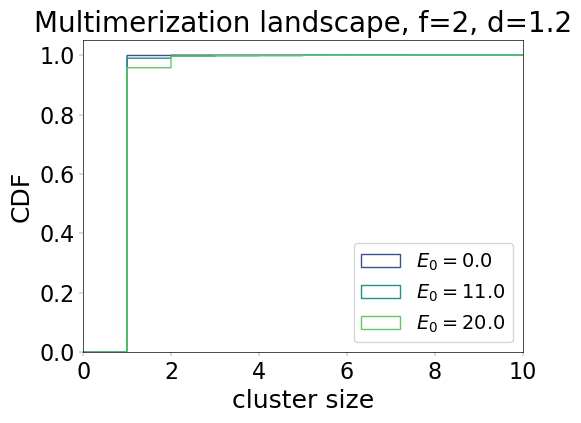

In [59]:
cluster_sizes = plot_multimerization(2, r=0.35, rep_r=1.1, cutoff=1.3, wrap=False)

In [56]:
Ds = []
for n in range(1, cluster_sizes.max()):
    Ds += [1./n] * np.sum(cluster_sizes == n) * n
len(Ds)

49940

In [58]:
1000 * 100

100000

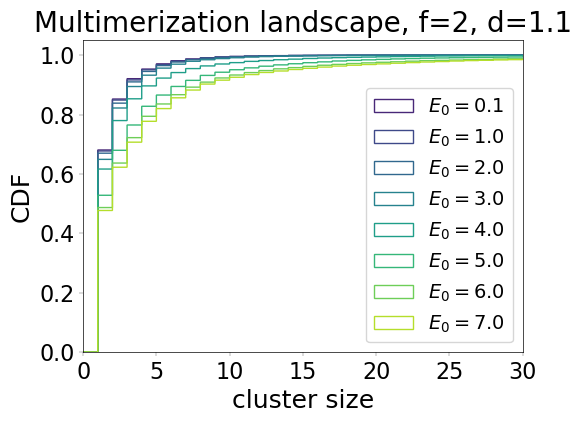

In [285]:
plot_multimerization(2, cutoff=1.1)

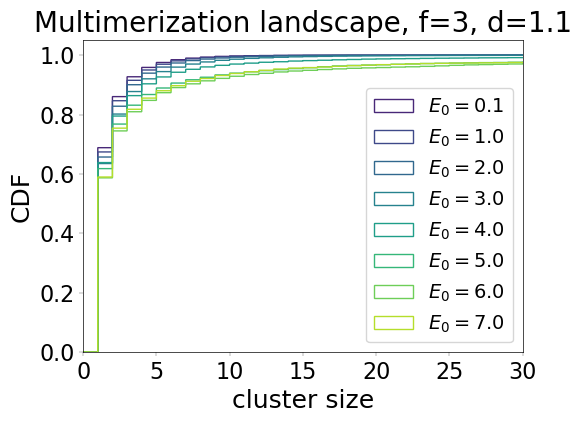

In [286]:
plot_multimerization(3, cutoff=1.1)

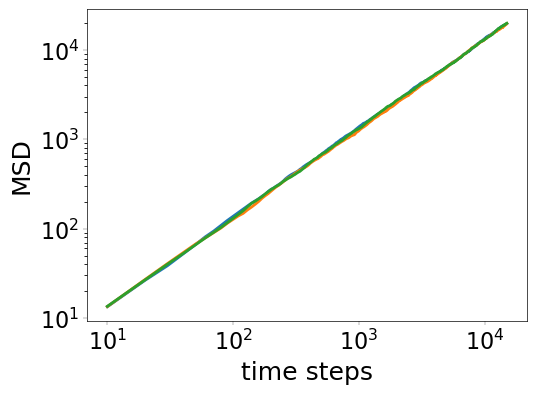

In [313]:
import pandas as pd

simdir = Path('/net/levsha/share/deepti/simulations/protein_mobility')
fig, ax = plt.subplots()
for E0 in [0.1, 6.0, 7.0]:
    path = simdir/f"N1000_f1_E0{E0}_v0.3_r0.25"
    msd_df = pd.read_csv(path/'sphere_msds_start5000_every_other_10.csv')
    ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                        label=f"$E_0={E0}$")
ax.set_xlabel("time steps")
ax.set_ylabel("MSD")
ax.set_xscale("log")
ax.set_yscale("log")